In [2]:
#%pip install -r requirements.txt

In [1]:
from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
from modeling_frcnn import GeneralizedRCNN
from processing_image import Preprocess, tensorize
from visualizing_image import SingleImageViz
from inference_lxmert import load_ckp, load_config, load_obj_data, show_image

ModuleNotFoundError: No module named 'transformers'

In [2]:
# load test data
raw_img = "test_one.jpg"
test_question = ["what clothing is the man wearing, who is on the horse?"]
img_tensor = tensorize(raw_img)
cfg = load_config()
objids, attrids = load_obj_data()
gqa_answers = json.load(open("gqa_answers.json"))

NameError: name 'tensorize' is not defined

In [43]:
# load models and model components
visualizer = SingleImageViz(img_tensor, id2obj=objids, id2attr=attrids)
preprocess = Preprocess(cfg)
frcnn = GeneralizedRCNN(cfg)
frcnn.load_state_dict(load_ckp(), strict=False)
frcnn.eval()
lxmert_tokenizer = LxmertTokenizer.from_pretrained("eltoto1219/lxmert-gqa-untuned")
lxmert = LxmertForQuestionAnswering.from_pretrained("eltoto1219/lxmert-gqa-untuned", num_qa_labels=len(gqa_answers))
lxmert.eval()

Model name 'bert-base-uncased' not found in model shortcut name list (unc-nlp/lxmert-base-uncased). Assuming 'bert-base-uncased' is a path, a model identifier, or url to a directory containing tokenizer files.
loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/eltoto/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-added_tokens.json from cache at None
loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-special_tokens_map.json from cache at None
loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-tokenizer_config.json from cache at None
loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-tokenizer.json from cache at None
https://s3.amazonaws.com/mo

LxmertForQuestionAnswering(
  (lxmert): LxmertModel(
    (embeddings): LxmertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LxmertEncoder(
      (visn_fc): LxmertVisualFeatureEncoder(
        (visn_fc): Linear(in_features=2048, out_features=768, bias=True)
        (visn_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (box_fc): Linear(in_features=4, out_features=768, bias=True)
        (box_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer): ModuleList(
        (0): LxmertLayer(
          (attention): LxmertSelfAttentionLayer(
            (self): LxmertAttention(
              (query)

In [44]:
# run frcnn
images, sizes, scales_yx = preprocess(img_tensor)
output_dict = frcnn(images, sizes, scales_yx=scales_yx)
output_dict = output_dict[0] # we only want the first image
features = output_dict.pop("roi_features")
boxes = output_dict.pop("boxes")
# add boxes and labels to the image
visualizer.draw_boxes(
    boxes,
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_scores"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_scores"),
)

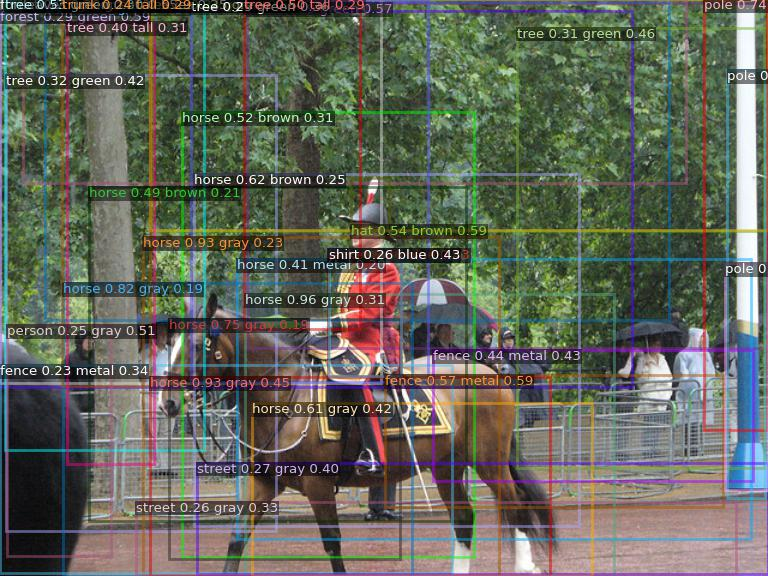

In [45]:
# visualize output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
showarray(visualizer._get_buffer())

In [46]:
# run lxmert
inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
)

output = lxmert(
    input_ids=torch.tensor(inputs.input_ids),
    attention_mask=torch.tensor(inputs.attention_mask),
    visual_feats=features.unsqueeze(0),
    visual_pos=boxes.unsqueeze(0),
    token_type_ids=torch.tensor(inputs.token_type_ids),
    return_dict=True,
    output_attentions=False,
)

In [47]:
# get prediction
logit, pred = output["question_answering_score"].max(-1)
print("Question:", test_question)
print("prediction:", gqa_answers[pred])
print("class ind:", int(pred))

Question: ['what clothing is the man wearing, who is on the horse?']
prediction: suit
class ind: 1105
